# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [15]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

from numpy import linalg as LA

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [16]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [17]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [18]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        self.eigenval = None
        self.eigenvec = None

    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT.copy()
        
        # we want D the dissimilarity matrix: (PMAT)_ij = 1 means there was a communication, i.e. those guys are "similar"
        self.D = np.full((self.PMAT.shape), 1) - self.PMAT        
        #self.D = np.multiply(self.D.sum(axis = 1).reshape(-1, 1), self.D)
        np.fill_diagonal(self.D, 0)

        nrow, ncol = self.PMAT.shape
        

        # 1. check if symmetric
        def check_symmetric(a, rtol=1e-05, atol=1e-08):
            return np.allclose(a, a.T, rtol=rtol, atol=atol)
        if(not check_symmetric(self.D)):
            print("Symmetrizing self.D")
            self.D = 1/2 * (self.D + self.D.T)
        
        # 2. calculate S^c
        Q = np.identity(nrow) - 1/nrow * np.full(self.D.shape, 1)
        self.S = -1/2 * np.matmul(np.matmul(Q, self.D), Q)
        
        # 3. perform spectral shift if necessary
        eig_min = LA.eigvalsh(self.S).min()

        if(eig_min < 0):
            print("Apply spectral shift")
            self.S = self.S - np.identity(nrow) * eig_min
            self.D = self.D - 2 * eig_min * (np.full(self.D.shape, 1) - np.identity(nrow))
            
        # 4. eigenvalue decomposition
        w, v = np.linalg.eigh(self.S)
        # descending order
        self.eigenval = w[::-1]
        self.eigenvec = v[:, ::-1]
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        eigenval = self.eigenval[0:(p)]
        eigenvec = self.eigenvec[:, 0:(p)]
        
        Xp = np.matmul(eigenvec, np.sqrt(np.diag(eigenval)))
        
        return Xp
        
        
        
        ## IMPLEMENT THIS METHOD


<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**: (Put your answer here)

Constant Shift Embedding:
The constand shift embedding is a method belonging to the area of pairwise clustering, i.e. clustering performed on a pairwise proximity matrix. In paper 1 it is proven that solving for optimal cluster assignments subjected to cost function 𝐻𝑝𝑐 is equivalent to a k-Means clustering in the embedding space (that is a euclidean space). The proof of the method exploits the fact that 𝐻𝑝𝑐

is invariante under symmetrization and off-diagonal shifts of the proximity matrix.

Algortithm:
Given a 𝑛×𝑛
proximity matrix 𝐷 with diag(𝐷)=0⃗ . Wlog 𝐷=𝐷𝑡 otherwise symmetrize. Next calculate:
i) "decomposition matrix" 𝑆𝑐=−12𝑄𝐷𝑄 where 𝑄=𝐼𝑛−1𝑛𝑒𝑛𝑒𝑡𝑛 the procjection matrix and 𝑒𝑛=[1,...,1].
ii) Apply diagonal shift on 𝑆𝑐, i.e. 𝑆̃ =𝑆𝑐−𝜆𝑛(𝑆𝑐)𝐼𝑛 where 𝜆𝑛(⋅) is the smallest eigenvalue of its argument.
iii) Calculate the Eigenvalue decomposition of 𝑆̃  from which the embedding can be derived.


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [19]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [20]:
CSE.fit(DATA)

Apply spectral shift


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

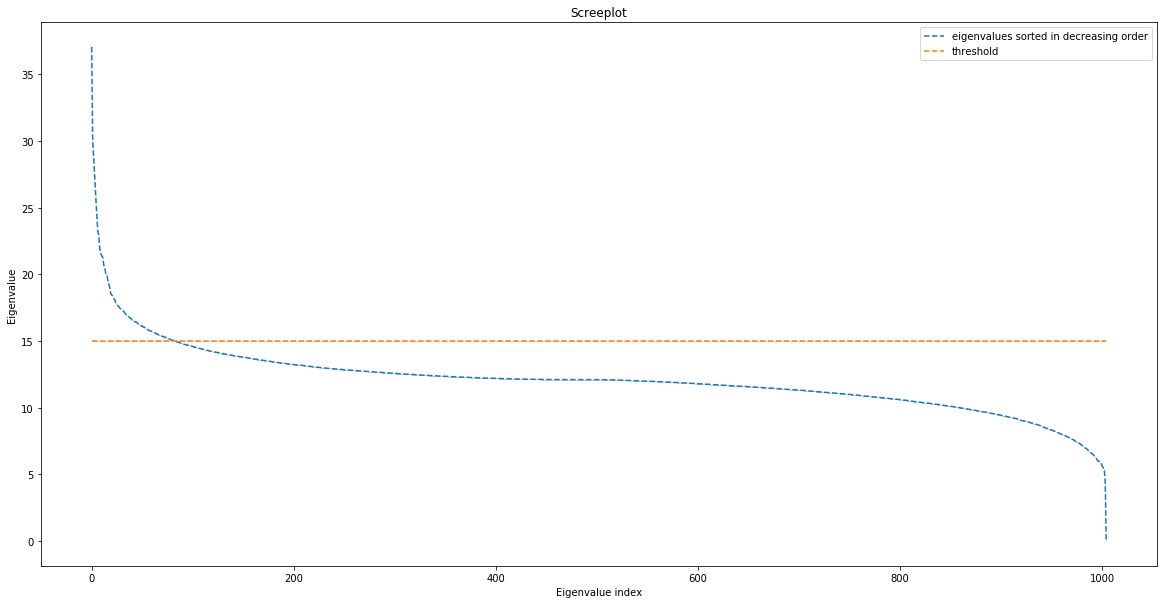

In [21]:
## Compute eigen-spectrum
threshold = 15
plt.figure(figsize=(20,10))
x = list(range(0, len(CSE.eigenval)))
plt.plot(x, CSE.eigenval, linestyle='dashed', marker='o',
     markerfacecolor='blue', markersize=0.1, label = 'eigenvalues sorted in decreasing order')
plt.plot(x, [threshold for i in x], linestyle='dashed', marker='o',
     markerfacecolor='blue', markersize=0.1, label = 'threshold')
plt.xlabel("Eigenvalue index")
plt.ylabel('Eigenvalue')
plt.title("Screeplot")
plt.legend()
plt.show()

In [22]:
p = np.where(CSE.eigenval >= threshold)[0][-1]
p

81

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [24]:
## Distance matrices
def matrix_clustering(p, k):
    X_p = CSE.get_embedded_vectors(p)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_p)

    indx_sorted = np.argsort(kmeans.labels_)
    D_sorted = distance_matrix(X_p, X_p)
    D_sorted = D_sorted[indx_sorted, :][:, indx_sorted]

    plt.figure(figsize=(20,10))
    plt.matshow(D_sorted, fignum=1)
    plt.title(" ".join(["#clusters = ", str(k), "; p = ", str(p)]))
    plt.gca().xaxis.tick_bottom()
    plt.show()  

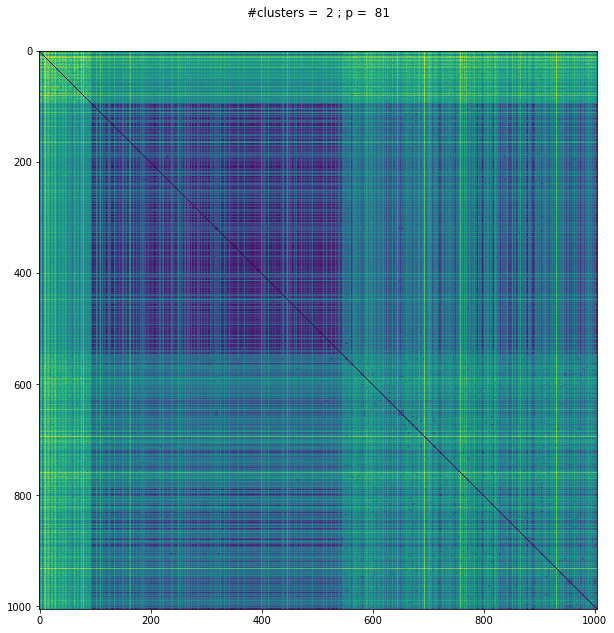

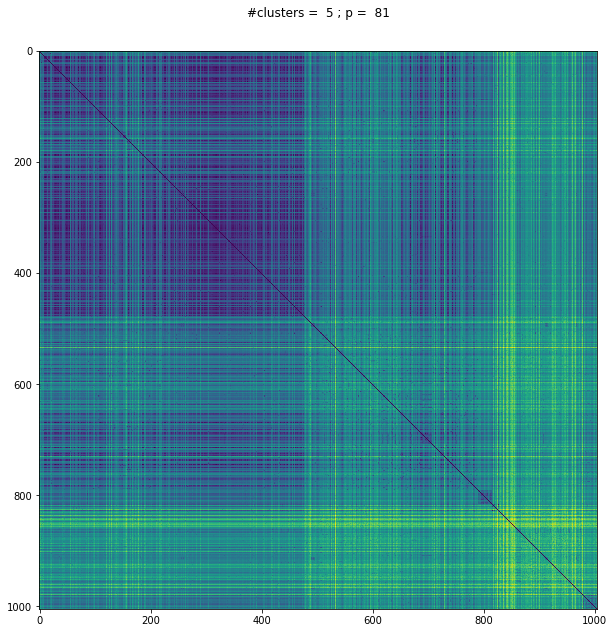

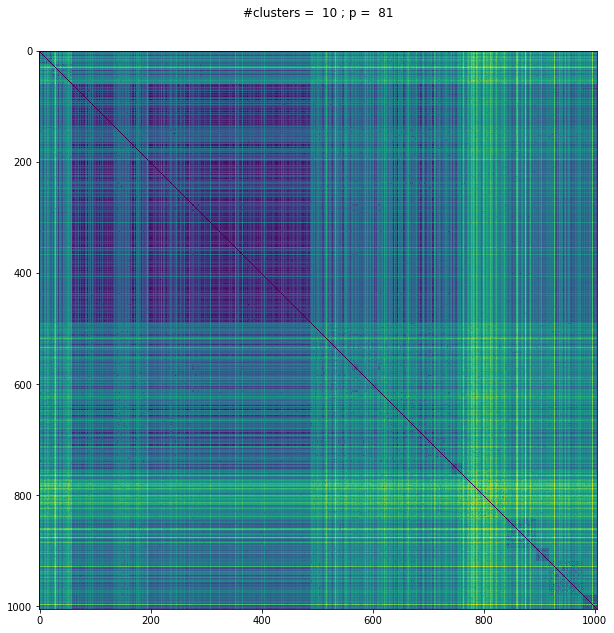

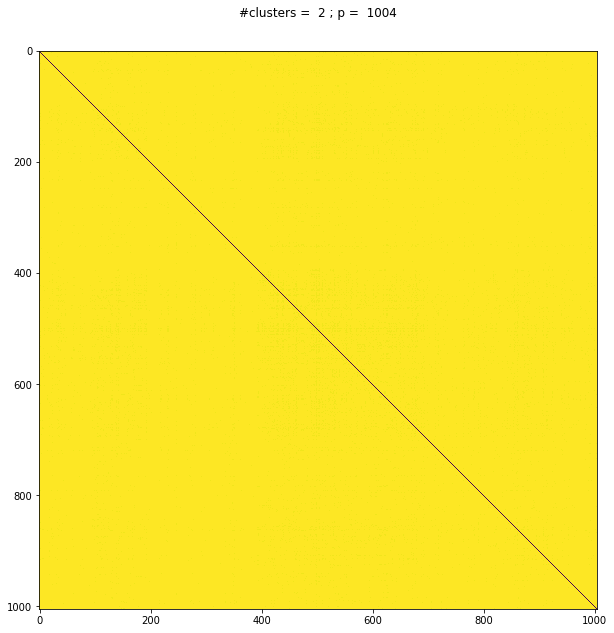

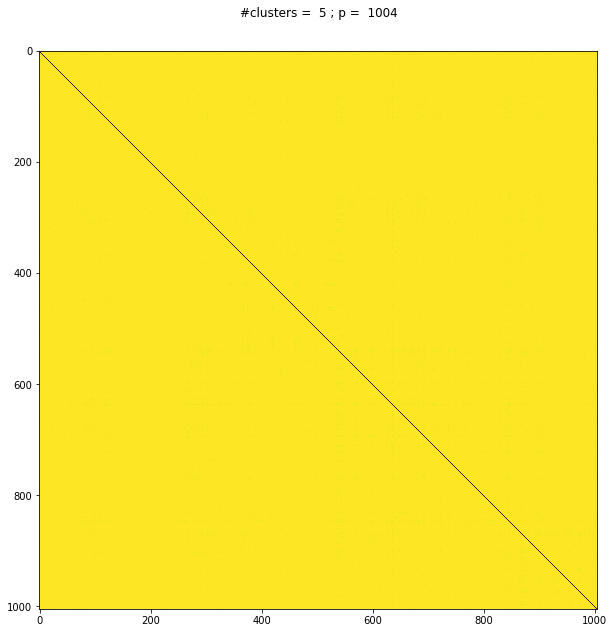

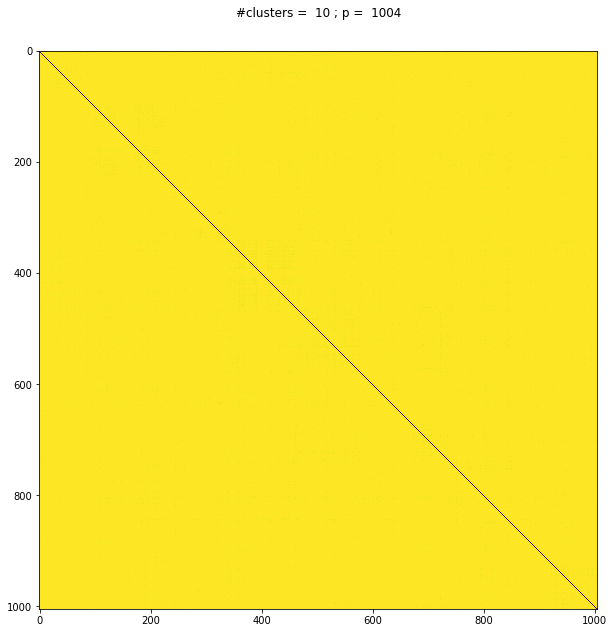

In [25]:
for p_iter in [p, len(CSE.eigenval)-1]:
    for k in [2, 5, 10]:
        matrix_clustering(p_iter, k)

In [ ]:
for k in [2, 5, 10]:
    matrix_clustering(5, k)

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [26]:
## Get embeddings, run K-MEANS and generate plots
def plot_clusters(p, k):
    X_p = CSE.get_embedded_vectors(p)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_p)
    
    if(p == 3):
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(" ".join(["#clusters = ", str(k), "; p = ", str(p)]))
        ax.scatter(X_p[:, 0], X_p[:, 1], X_p[:, 2], c = kmeans.labels_, alpha = 1/2)
        #ax.title(" ".join(["#clusters = ", str(k), "; p = ", str(p)]))
        #ax.show()  
    else:
        plt.figure(figsize=(20,10))
        plt.scatter(X_p[:, 0], X_p[:, 1], c = kmeans.labels_, alpha = 1/2)
        plt.title(" ".join(["#clusters = ", str(k), "; p = ", str(p)]))
        plt.show()  
        

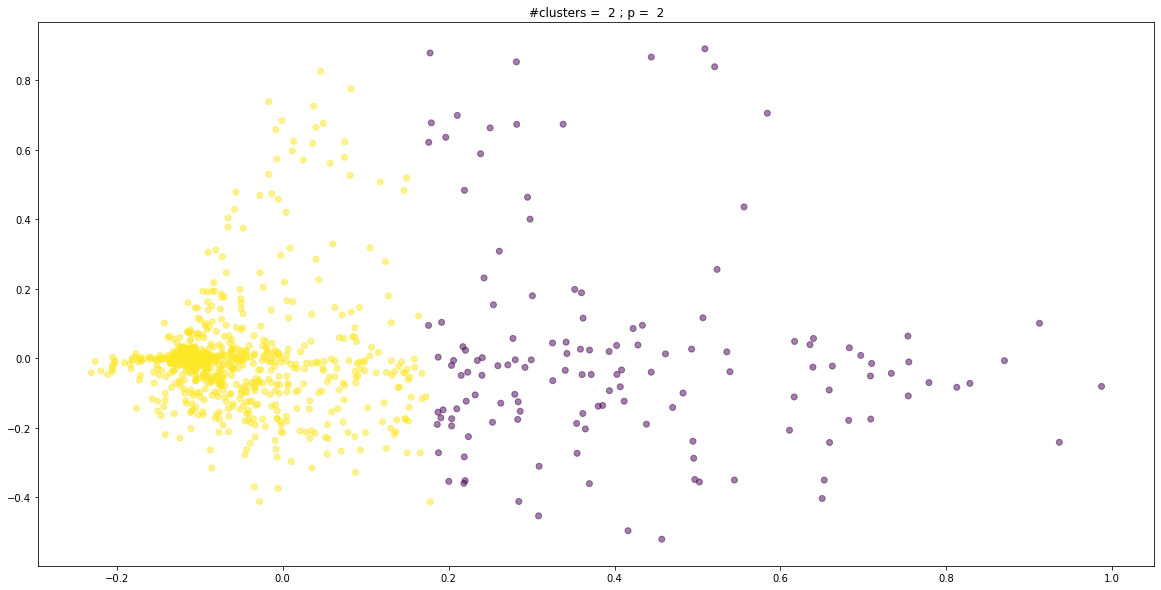

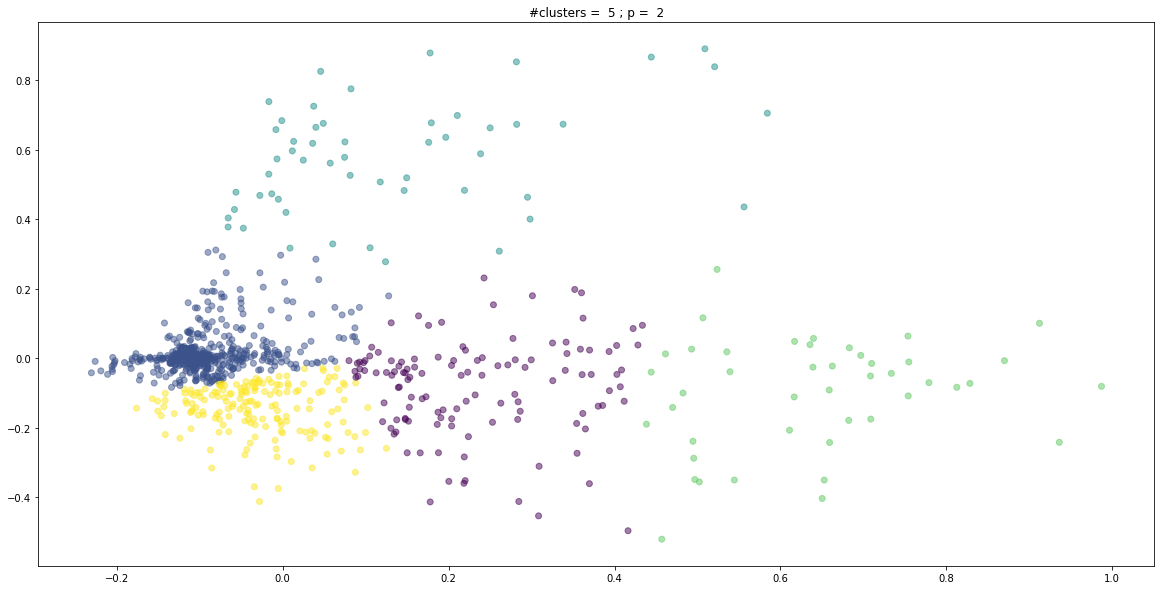

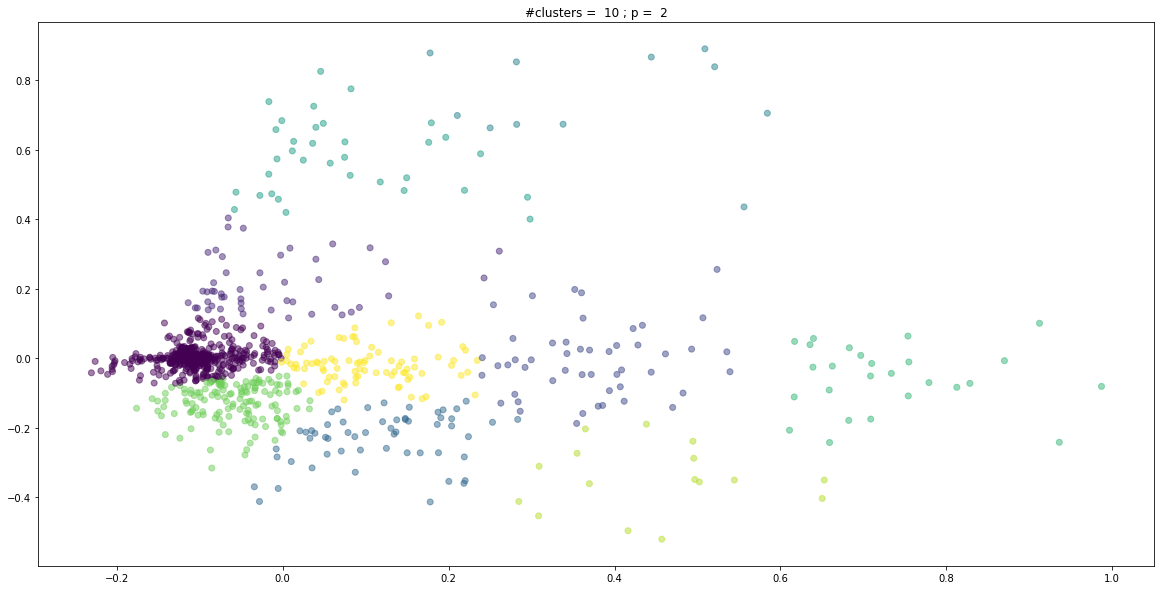

In [27]:
## p = 2
p = 2
for k in [2, 5, 10]:
    plot_clusters(p, k)

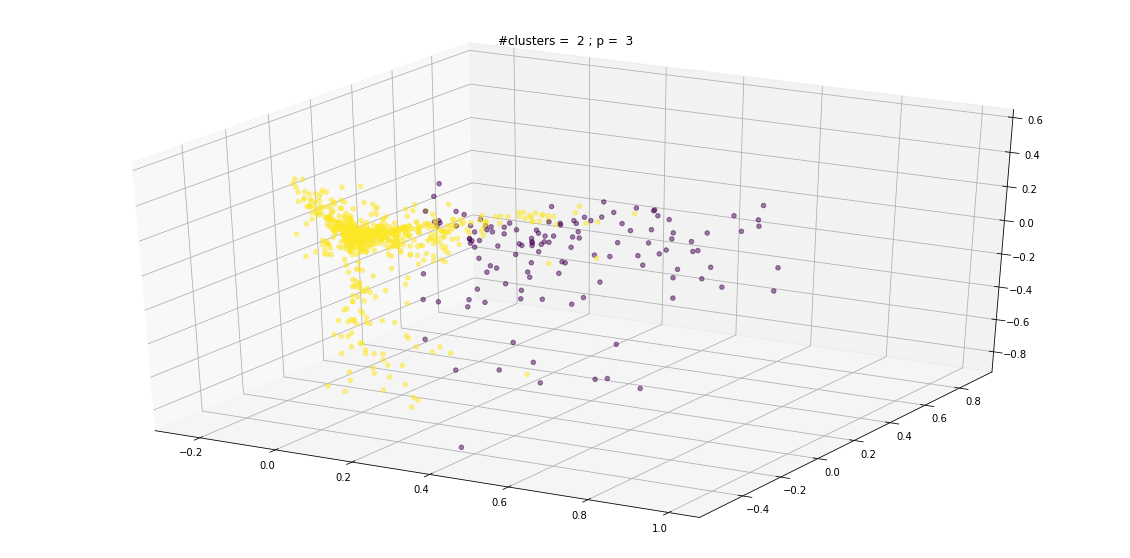

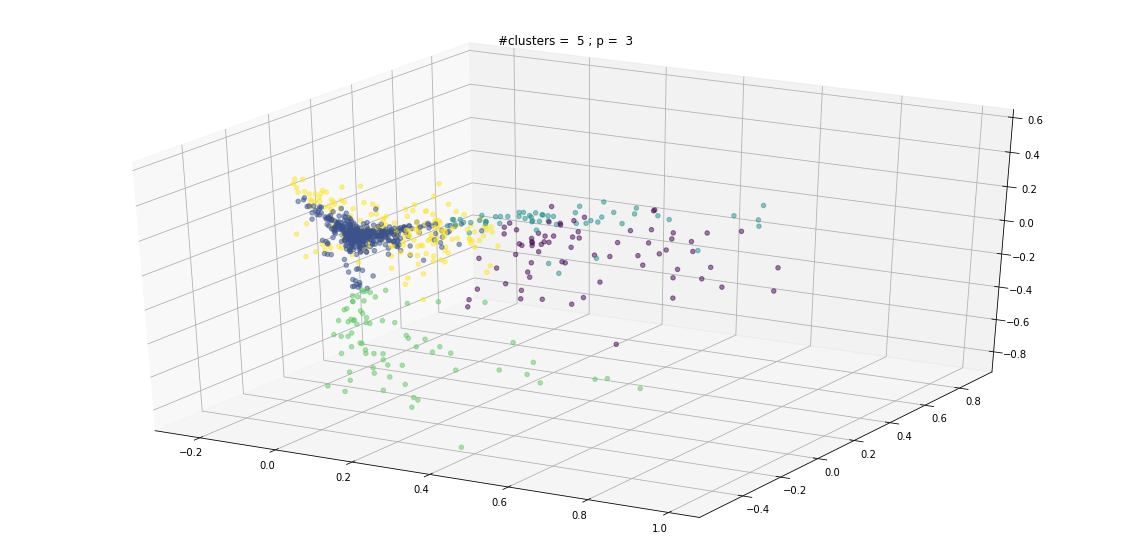

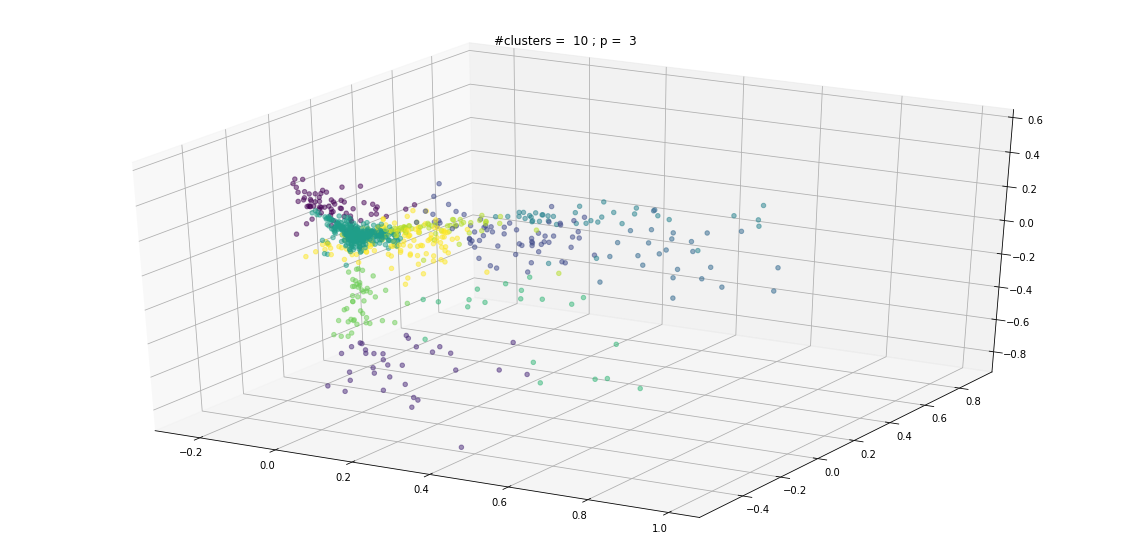

In [28]:
## p = 3
p = 3
for k in [2, 5, 10]:
    plot_clusters(p, k)

In [29]:
## choose p > 3, for example, p = p_opt 
## clusted computed p-dimentional embeddings and project them onto 2-dimensional space for visualization
## using PCA, LL, t-SNE or something else
from sklearn.manifold import TSNE
X_p = CSE.get_embedded_vectors(p_opt)

NameError: name 'p_opt' is not defined

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [ ]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [ ]:
## Here you can provide plots and calculations

Please, write here your explanations, observation and thoughts about results of the experiments above.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.